# Authorship Verification

In [38]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import scipy.spatial.distance as scidist

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import mpl_axes_aligner

## Loading

In [39]:
def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'NOU-P':
                        verse.append(('NOU-P', 'NOU-P'))
                    else:
                        verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [40]:
import lxml.etree

def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text if l.text else "" for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text if p.text else "" for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            lemma = lemma or ""  # Ensure lemma is not None
            pos = pos or ""      # Ensure pos is not None
            
            for l, p in zip(lemma.split('+'), pos.split('+')):
                if p == 'NOU-P':
                    verse.append(('NOU-P', 'NOU-P'))
                else:
                    verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [41]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['genre'].isin(['Epiek', 'Proza'])]
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,provenance,date_range,genre,subgenre,exclude
80,grimbergse_oorlog_cont,Grimbergse oorlog (cont),NaN,cdrom-mnl,1300-1350,Epiek,Historiografie,NaN
166,roman_van_perchevael,Perchevael,NaN,cdrom-mnl,1300-1350,Epiek,Arthur,NaN
11,bediedenisse_van_der_missen,Bediedenisse van der missen,NaN,cdrom-mnl,1340-1360,Epiek,Religie,NaN
104,roman_van_lancelot_fragm_br,Lancelot,NaN,cdrom-mnl,1300-1350,Epiek,Arthur,NaN
123,madelgijs_fragm_lo,Madelgijs,NaN,cdrom-mnl,1350-1400,Epiek,Karel,NaN
45,"Der naturen bloeme, handschrift D",Der naturen bloeme,Jacob van Maerlant,CG1,1287-1287,Epiek,Didactiek,NaN
221,spiegel_historiael__2,Spiegel historiael (P2),Philip Utenbroeke,cdrom-mnl,1393-1402,Epiek,Historiografie,NaN
99,roman_van_jonathas_ende_rosafiere_fragm_a,Jonathas ende Rosafiere,NaN,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
40,cyromanchie_van_den_pape_van_den_hamme_chiromantie,Cyromanchie van den pape van den Hamme,NaN,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
155,ongeidentificeerd_6,Ongeïdentificeerd (6),NaN,cdrom-mnl,1375-1400,Epiek,Karel,NaN


In [42]:
meta_df.tail()

,id,title,author,provenance,date_range,genre,subgenre,exclude
282,willem_van_oringen,Willem van Oringen,NaN,cdrom-mnl,1300-1350,Epiek,Karel,NaN
285,Wrake van Ragisel,Wrake van Ragisel,NaN,CG1,1280-1260,Epiek,Arthur,NaN
286,wrake_van_ragisel,Wrake van Ragisel,NaN,cdrom-mnl,1300-1350,Epiek,Arthur,NaN
287,Merlijn-Velthem,Merlijn-continuatie,Lodewijk van Velthem,cdrom-mnl,1415-1435,Epiek,Arthur,NaN
288,sidrac,Sidrac,Jan van Boendale,cdrom-mnl,1318-1329,Proza,Proza,NaN


In [43]:
works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml_galahad_BY-split/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'subgenre', 'text'])

Wrake van Ragisel                                 : 100%|█| 165/165 [00:11<00:00


## Segmentation 

In [48]:
len(work_df[work_df['title'].str.contains('Sidrac')]['text'].iloc[0])

1598

In [49]:
def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['subgenre']]
        
        if row['title'] == 'Van Saladijn':
            text = text[::2] + text[1::2]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=False, incl_pos=False, segment_length=5000) # segment length zodat Korte kroniek er nog bij kan
segment_df.sample(5)

100%|████████████████████████████████████████| 165/165 [00:00<00:00, 384.36it/s]


,title,author,genre,subgenre,segment-idx,text
522,Roman der Lorreinen II,NaN,Epiek,Karel,7,"[op, een, tijd, ik, wanen, gijs, vroed, wel, zijn, dat, gij, taken, een, zoen, maken, tussen, de, koning, NOU-P, en, tussen, NOU-P, die, hier, staan, als, hier, nog, menig, weten, daar, hij, die, goed, stad, van, messen, en, al, dat, land, dat, daar, toe, zijn, te, zoenen, geven, de, koning, NOU-P, die, het, vorten, geven, NOU-P, uw, zoon, in, huwelijk, met, de, dochter, zijn, daar, geloven, die, hertog, NOU-P, en, de, koning, NOU-P, mede, dat, nimmermeer, te, geer, stede, joen, noch, met, geen, zin, jegen, NOU-P, die, koningin, spreken, zullen, goed, noch, kwaad, want, NOU-P, hebben, van, haar, daad, wonder, ...]"
442,Reinaerts historie,NaN,Epiek,Dier,7,"[een, strik, vangen, daar, het, immer, het, lijf, zullen, hebben, laten, maar, dat, die, man, tot, zijn, baten, voorbij, zullen, gaan, en, zien, hoe, het, staan, daar, het, zeer, oproepen, al, met, ootmoed, dat, hij, hij, helpen, daar, uiter, noot, of, het, zullen, daar, blijven, dood, de, man, verdenken, zijn, verdriet, loven, dat, du, ik, niet, venijnen, ne, zullen, noch, schaden, ik, zullen, du, uiter, noot, ontladen, dat, serpent, zijn, des, bereid, en, zweren, hij, een, duur, eed, niet, te, schadigen, in, enig, zaak, toen, lossen, hij, het, uit, dat, ongemak, en, zijn, een, stuk, te, samen, gaan, toen, worden, ...]"
792,Tien plaghen ende die tien ghebode,NaN,Epiek,Didactiek,2,"[eren, op, dat, gij, willen, te, NOU-P, keren, en, u, ziel, zaligheid, meren, nu, horen, van, de, vijfde, plaag, die, geschieden, in, dat, dag, aan, de, lieden, met, al, aan, zij, zijn, vallen, een, bitterlijk, plaag, koning, hertog, en, graf, en, dat, volk, al, gemeen, oud, jong, groot, en, klein, beide, kind, en, wijf, plagen, worden, haar, al, lijf, want, aan, zij, worden, vinden, blad, en, wond, zweer, opblazen, dat, er, luttel, genezen, dus, lijden, zij, gemeen, noot, dat, er, menig, moeten, blijven, dood, van, die, gemeen, plaag, groot, die, blad, en, de, wond, die, aan, de, lieden, worden, vinden, ...]"
127,Der mannen ende vrouwen heimelijcheit,NaN,Epiek,Didactiek,1,"[NOU-P, enig, vader, en, heer, zonder, begin, en, immermeer, zonder, en, wezen, zullen, hij, zijn, ik, groot, en, smal, mijn, ziel, mijn, lijf, van, kwaad, ding, ne, laten, ik, heer, niet, gehengen, te, doen, dat, onnuttelijk, zijn, ook, bidden, ik, heer, dat, gij, ik, helpen, nu, te, deze, stond, zo, dat, moeten, worden, vinden, dit, boek, dat, ik, hier, dichten, zullen, u, hulp, help, begeren, boven, al, want, willen, gij, ik, in, stade, staan, zo, willen, ik, nu, hier, aangaan, van, natuur, die, meest, worden, die, nog, nie, worden, horen, van, enig, man, te, neger, tijd, NOU-P, moeder, NOU-P, gij, zijn, ...]"
335,Limborch,NaN,Epiek,Ridder,14,"[hij, brengen, met, hij, een, konrood, van, saracijn, en, zingen, zeer, van, NOU-P, haar, heer, mijn, her, NOU-P, die, banderzijn, hij, gereden, te, deze, strijd, wapenen, hij, edellijk, na, die, wijze, van, NOU-P, en, nemen, NOU-P, zijn, zwaard, nimmer, hier, begeren, en, komen, alzo, ten, krijt, rijden, met, ootmoede, en, met, simpelheid, en, de, koning, en, zijn, lieden, mede, die, koning, die, vragen, doen, de, saracijn, openbaar, of, hij, willen, houden, dat, daar, zijn, te, voren, spreken, gestaden, hij, zeggen, dat, hij, het, gaarne, doen, toen, togen, zij, achter, in, beide, zijde, en, laten, hij, beide, die, schier, strijden, zullen, ...]"


In [50]:
len(segment_df[segment_df['title'].str.contains('duwaert')]['text'].iloc[0])

5000

In [51]:
len(segment_df[segment_df['title'].str.contains('idrac')]['text'].iloc[0])

5000

## Combinations

In [52]:
calib_df = segment_df[
    (segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem'})) | 
    (segment_df['title'].isin({'Jans teesteye'}))
]

trg_df = segment_df[segment_df['title'].isin({#'Brabantsche yeesten (B1-3)', 
                                              #'Brabantsche yeesten (B4-5)',
                                              'Brabantsche yeesten (B5)',
                                              'Korte kroniek van Brabant (korte versie 1)',
                                              'Korte kroniek van Brabant (lange versie)',
                                              'Der leken spieghel',
                                              'Jans teesteye',
                                              'Van den derden Eduwaert',
                                              'Melibeus',
                                              'Boec Exemplaer',
                                              'Dietsche doctrinale',
                                              'Boec vander wraken',
                                              'Sidrac'
                                             })]
                                              # 
                                              
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']

#calib_df = calib_df[calib_df['title'] != 'Heymelijchede der heymelijcheit']

In [53]:
calib_df[['author', 'title']].value_counts()

author                title                          
Jacob van Maerlant    Spiegel historiael (P1-P4)         98
                      Historie van Troyen                47
                      Rijmbijbel                         38
Lodewijk van Velthem  Merlijn-continuatie                32
                      Spiegel historiael (P5)            32
Jacob van Maerlant    Der naturen bloeme                 18
                      Alexanders geesten                 15
                      Sinte Franciscus leven             11
Lodewijk van Velthem  Spiegel historiael (P4)            7 
Jan van Boendale      Jans teesteye                      4 
Jacob van Maerlant    Heymelijchede der heymelijcheit    2 
Name: count, dtype: int64

In [54]:
trg_df[['title']].value_counts()

title                                   
Der leken spieghel                          23
Sidrac                                      12
Dietsche doctrinale                         7 
Boec vander wraken                          6 
Brabantsche yeesten (B5)                    4 
Jans teesteye                               4 
Melibeus                                    4 
Korte kroniek van Brabant (lange versie)    2 
Van den derden Eduwaert                     2 
Name: count, dtype: int64

In [55]:
combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
print(combos['authorship'].value_counts())
combos.sample(5)

authorship
D    31
S    24
Name: count, dtype: int64


,title1,title2,authorship
19,Heymelijchede der heymelijcheit,Historie van Troyen,S
22,Heymelijchede der heymelijcheit,Spiegel historiael (P1-P4),S
16,Der naturen bloeme,Merlijn-continuatie,D
28,Historie van Troyen,Sinte Franciscus leven,S
11,Der naturen bloeme,Historie van Troyen,S


In [56]:
def identity(x):
    return x

def bigrams(text):
    for i in range(len(text)-1):
        if 'NOU-P' not in text[i:i+2]:
            yield '-'.join((sorted(text[i:i+2])))
            
def unigrams(text):
    for i in range(len(text)):
        if 'NOU-P' not in text[i]:
            yield text[i]

params = {'use_idf': True,
          'max_features': 5000,
          'analyzer': 'word',
          #'ngram_range': (1,3),
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(calib_df['text'].astype(str).tolist() + trg_df['text'].astype(str).tolist())
X = vectorizer.transform(calib_df['text'].astype(str).tolist()).toarray()

In [57]:
# Sanity check to make sure all proper nouns are ignored and not present in the vector (important for Korte Kroniek)

# get the features from the vectorizer
feature_names = vectorizer.get_feature_names_out()
contains_nou_p = any("NOU-P" in feature for feature in feature_names)

# result
print("Does the feature list contain 'NOU-P'?", contains_nou_p)

Does the feature list contain 'NOU-P'? False


In [58]:
calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances = calib_distances[~calib_distances['distance'].isna()]
calib_distances

,title1,title2,authorship,distance
0,Alexanders geesten,Der naturen bloeme,S,0.361519
1,Alexanders geesten,Der naturen bloeme,S,0.145084
2,Alexanders geesten,Der naturen bloeme,S,0.140090
3,Alexanders geesten,Der naturen bloeme,S,0.133558
4,Alexanders geesten,Der naturen bloeme,S,0.161615
...,...,...,...,...
38181,Spiegel historiael (P4),Spiegel historiael (P5),S,0.128085
38182,Spiegel historiael (P4),Spiegel historiael (P5),S,0.117121
38183,Spiegel historiael (P4),Spiegel historiael (P5),S,0.129800
38184,Spiegel historiael (P4),Spiegel historiael (P5),S,0.131696


max(f1)=0.0 @ theta=0.8515


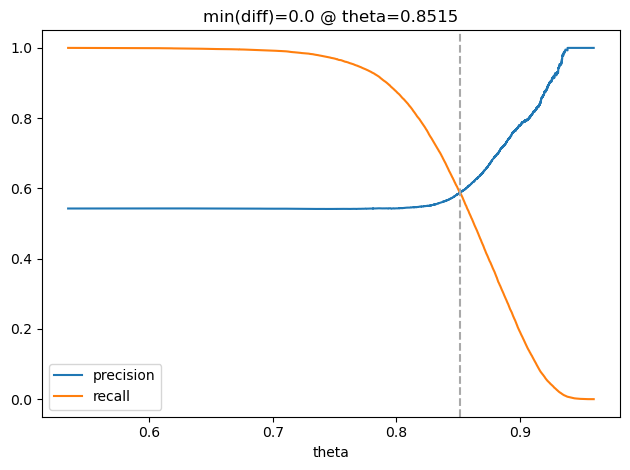

In [59]:
distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
diffs = np.abs(precisions - recalls)
max_diff_idx = np.array(diffs).argmin()
max_diff = diffs[max_diff_idx]
max_diff_th = thresholds[max_diff_idx]
print(f'max(f1)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.axvline(max_diff_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'min(diff)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')
plt.tight_layout()

In [60]:
calib_thresh = 1 - max_diff_th
calib_thresh

0.14850793795842876

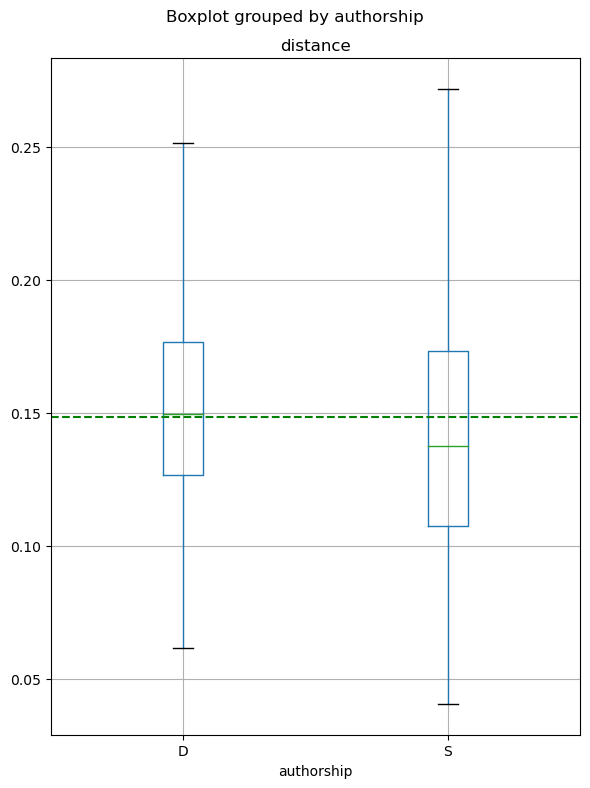

In [61]:
calib_distances.boxplot('distance', 'authorship', figsize=(6, 8), showfliers=False)
plt.axhline(calib_thresh, c='green', ls='--')
plt.tight_layout();

##### Target

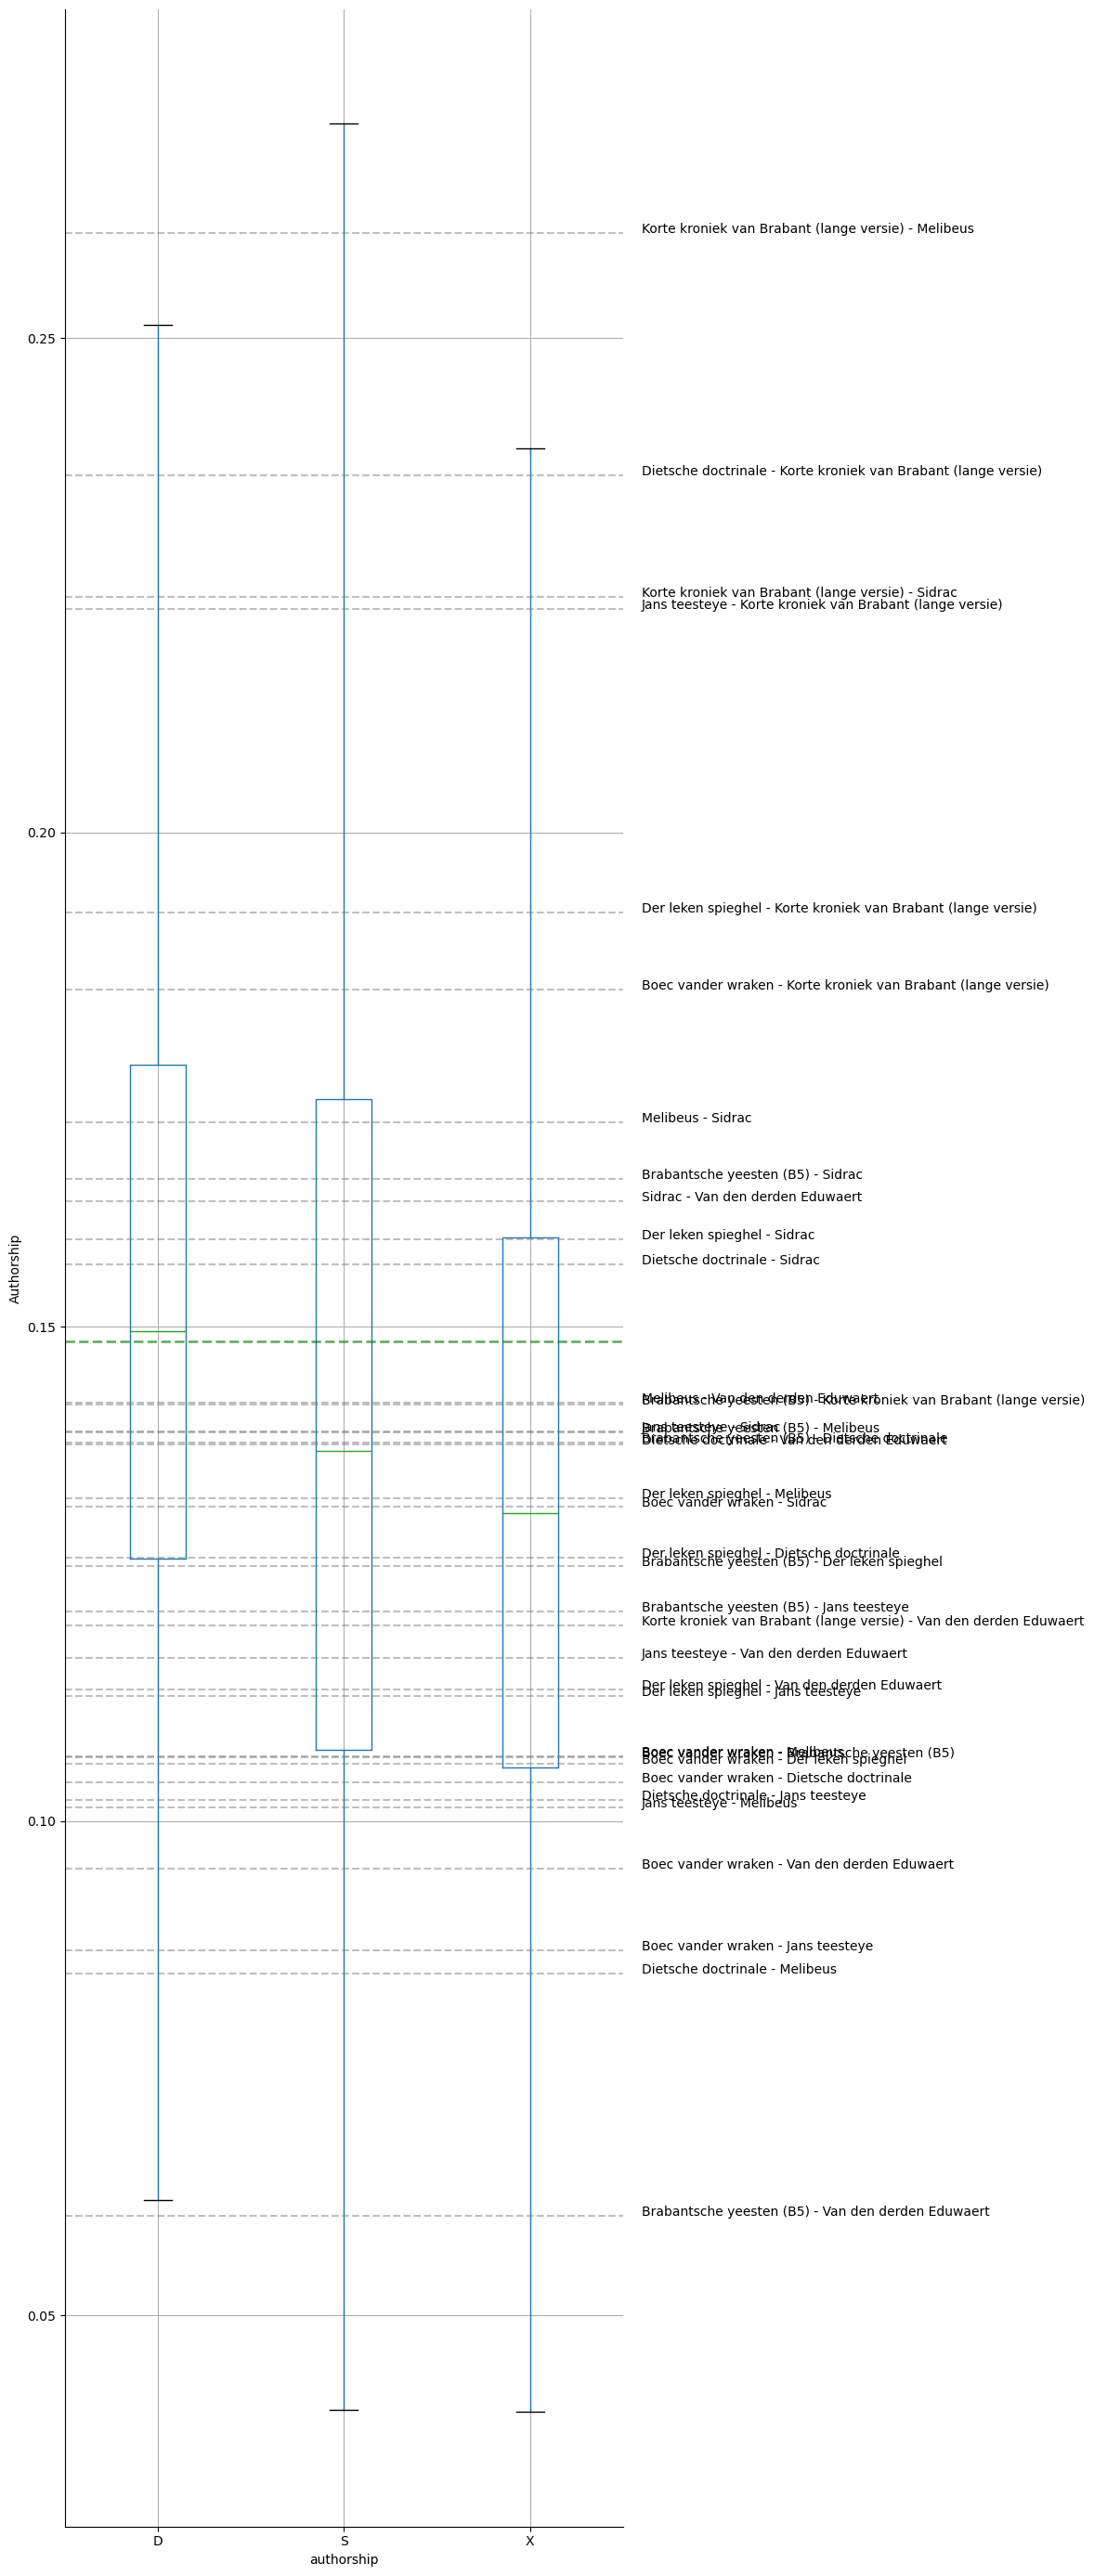

In [62]:
trg_X = vectorizer.transform(trg_df['text'].astype(str).tolist()).toarray()

combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'

trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
distances = pd.concat([calib_distances, trg_distances])

distances.boxplot('distance', 'authorship', figsize=(12, 28), showfliers=False)
sb.despine()
plt.axhline(calib_thresh, c='green', linewidth=2, ls='--', alpha=.6)

for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            plt.gca().axhline(d.mean(), c='grey', ls='--', alpha=.5)
            plt.annotate(' - '.join(m), xy=[plt.gca().get_xlim()[1]+0.1, d.mean()],
                         annotation_clip=False)
            
plt.title('')
plt.ylabel('Distance')
plt.ylabel('Authorship')
plt.suptitle('')

plt.tight_layout();

Dietsche doctrinael & Melibeus: zien we hier Albertanus of Boendale?

B5 en Eduwaert: inhoud nakijken maar hoogstwaarschiinlijk Boendale

Meeste afstand tussen BY 1-3 / 4-5 en andere werken: te verwachten
    Bij BY 1-3 en DD vergelijken we eigenlijk ook Maerlant en Albertanus
    
Dietsche doctrinael: 

BY 5 scoort relatief hoog met de rest

## Networks

In [63]:
segment_df = segment(work_df, rhyme_only=False, incl_pos=False, segment_length=5000) 
segment_df.sample(5)

100%|████████████████████████████████████████| 165/165 [00:00<00:00, 356.58it/s]


,title,author,genre,subgenre,segment-idx,text
338,Limborch,NaN,Epiek,Ridder,17,"[hij, menig, eer, zo, dat, zij, begeren, zeer, zandersdag, te, hebben, strijd, zij, gaan, na, die, etenstijd, beide, ridder, en, knaap, ter, herberg, waart, slapen, die, heiden, die, in, de, tent, liggen, die, hij, nu, een, deel, ontzien, meer, dan, zij, te, voren, doen, gaan, hij, al, beraden, en, zeggen, heer, nu, hier, te, raad, wij, hebben, hebben, schade, bij, de, heer, van, de, stad, entrouwen, wij, moeten, ons, bet, verzien, en, wijselijk, al, zijn, wij, een, deel, rijk, zij, hebben, vroom, lieden, binnen, nu, raden, ons, hoe, wij, gewinnen, deze, stad, al, zijn, gij, groot, willen, hij, gij, hebben, ...]"
322,Limborch,NaN,Epiek,Ridder,1,"[oogmoedig, NOU-P, geweldig, heer, die, ooit, worden, en, immermeer, zien, zullen, in, volmaaktheid, een, NOU-P, in, de, drievuldigheid, tegenwoordig, in, elk, stad, volkomenlijk, wie, twijfelen, dat, sterk, en, gedogzaam, almachtig, ontfermig, NOU-P, gerechtig, want, NOU-P, zeggen, zekerlijk, ons, heer, zo, zijn, aardrijk, en, al, dat, er, binnen, ne, zijn, want, niemand, ne, maken, dan, hij, alzo, waarlijk, als, het, zijn, waar, en, ik, het, geloof, openbaar, zonder, twijfel, geheellijk, moeten, gij, ik, heer, van, hemelrijk, gunnen, dat, ik, volmaken, mogen, mijn, gedicht, daar, ik, na, pogen, met, al, mijn, hert, nacht, en, dag, want, zonder, u, niet, zien, ne, mogen, ...]"
547,Segheliin van Jerusalem,Loy Latewaert,Epiek,Kruisvaart,2,"[hebben, wachten, en, elk, hebben, een, zwaard, brengen, en, roepen, nu, zij, du, dood, zij, togen, haar, zwaard, bloed, en, zegelen, gij, ook, dat, zijn, zij, roepen, nu, neken, ons, pijn, zien, daar, een, zwaard, behagel, het, zijn, waard, omtrent, een, omnagel, het, zijn, zo, roest, ik, wanen, bloed, het, snijden, wel, boter, zijn, het, gloeien, hij, ne, zien, nooit, goed, zwaard, NOU-P, zeggen, ik, hebben, zo, waard, alzo, waard, als, gij, dat, u, al, zijn, zij, klaar, en, nu, het, mogen, wel, zien, alzo, goed, helpen, het, komen, uit, de, gloed, spreken, een, die, daar, zijn, het, zijn, veel, ...]"
777,Spieghel der menscheliker behoudenesse,NaN,Epiek,Didactiek,5,"[en, leiden, als, ik, het, hebben, verstaan, door, dat, water, van, de, NOU-P, als, deze, kind, aldus, te, samen, in, het, land, van, NOU-P, komen, ne, mogen, zij, daar, gaan, noch, rijden, zijn, moeten, door, de, NOU-P, lijden, en, daar, bij, zijn, ons, wel, beduiden, dat, wij, ne, mogen, komen, niet, te, ons, land, van, belof, dat, zijn, ten, zoet, hemels, hof, wij, ne, moeten, lijden, verstaan, dat, voren, door, de, doopsel, batten, door, deze, NOU-P, alzo, ik, merken, dragen, zij, zijlieden, erk, in, de, middelwaard, voorwaar, en, de, erk, blijven, staan, daar, oud, lieden, min, en, meest, leiden, de, ...]"
365,Merlijn-continuatie,Lodewijk van Velthem,Epiek,Arthur,2,"[op, de, koning, en, zeggen, ter, tijd, laten, ons, al, op, hij, varen, te, een, maal, al, zonder, sparen, en, laten, ons, ter, aarde, werpen, nu, anders, ne, meesteren, wij, de, niet, zeggen, ik, -, toen, loeven, zij, dat, al, en, nemen, daar, groot, schacht, en, reden, daarnaar, op, hij, al, met, haar, schacht, en, steken, op, hij, met, kracht, op, zijn, schild, aldaar, ter, stede, en, op, zijn, halsberg, mede, maar, zijn, halsberg, zijn, zo, goed, dat, hij, haar, steek, al, wederstaan, en, arteur, zijn, stout, in, de, weer, maar, zij, lopen, op, hij, daar, zo, zeer, dat, zijn, ...]"


In [77]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               width=1000,
               height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="5pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    
    show(p)
    
    return p

sub_df = segment_df[segment_df['subgenre'].isin({'Didactiek', 'Historiografie', 'Proza'})]
sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]
sub_df['text'] = sub_df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))


params = {'use_idf': True,
          'max_features': 500,
          'analyzer': 'word',
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=20)
X = pca.fit_transform(BOW)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

plot = scatterplot(X, sub_df, label_column='title', color_column='title')
plot

figure(id='p8641', ...)

In [65]:
# Also save
#import selenium
from bokeh.io.export import export_svgs
plot.output_backend = "svg"  # Enable SVG output
export_svgs(plot, filename="../figures/scatterplot.svg")

['../figures/scatterplot.svg']

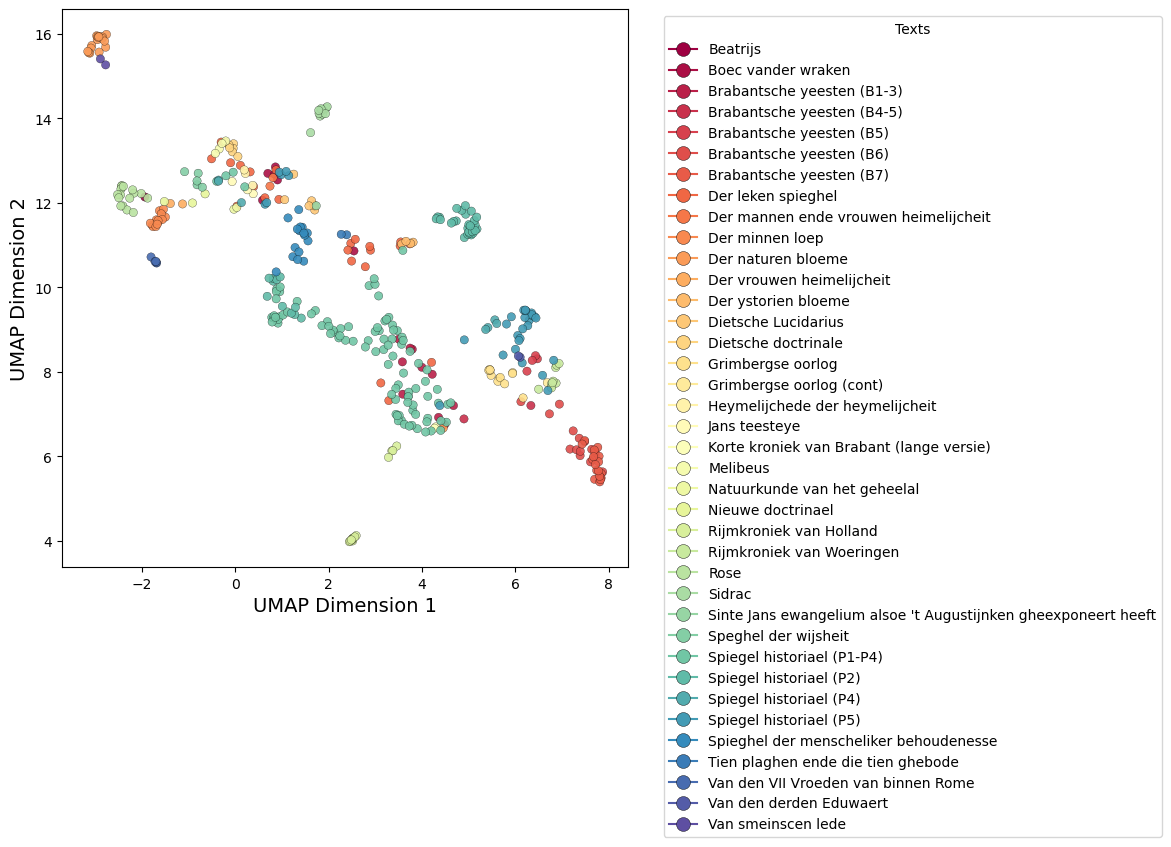

In [78]:
import umap.umap_ as umap

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=20)
X_pca = pca_model.fit_transform(BOW)

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(sub_df['title'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
text_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'{text}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, text in enumerate(text_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Texts", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
#plt.savefig('figures-and-tables/scatterplot_1.svg', dpi=600, bbox_inches='tight')
plt.show()

In [79]:
import plotly.express as px
import pandas as pd

# Map categorical titles to a numeric scale for coloring
sub_df['title_numeric'] = pd.Categorical(sub_df['title']).codes

# Add UMAP coordinates back to the dataframe for ease of access
sub_df['UMAP Dimension 1'] = X_umap[:, 0]
sub_df['UMAP Dimension 2'] = X_umap[:, 1]

# Use a color scale based on the numeric mapping of titles
fig = px.scatter(sub_df, x='UMAP Dimension 1', y='UMAP Dimension 2', 
                 color='title_numeric', hover_data=['title'], 
                 labels={'title': 'title'}, 
                 color_continuous_scale='Spectral')  # You can change 'Viridis' to any other scale

# Add title and axis labels
fig.update_layout(title='UMAP Scatter Plot of Charter Texts by Scribes',
                  xaxis_title='UMAP Dimension 1',
                  yaxis_title='UMAP Dimension 2',
                  width=800,  # Adjust width
                  height=600,  # Adjust height to make it square
                  margin=dict(l=40, r=40, t=40, b=40)  # Adjust margins to avoid clipping
)

# Show interactive plot
fig.show()

In [82]:
# nog met andere vergelijken? sub_df = segment_df[segment_df['title'].isin({''})]
sub_df = trg_df
sub_df['text'] = sub_df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
BOW = StandardScaler().fit_transform(BOW)

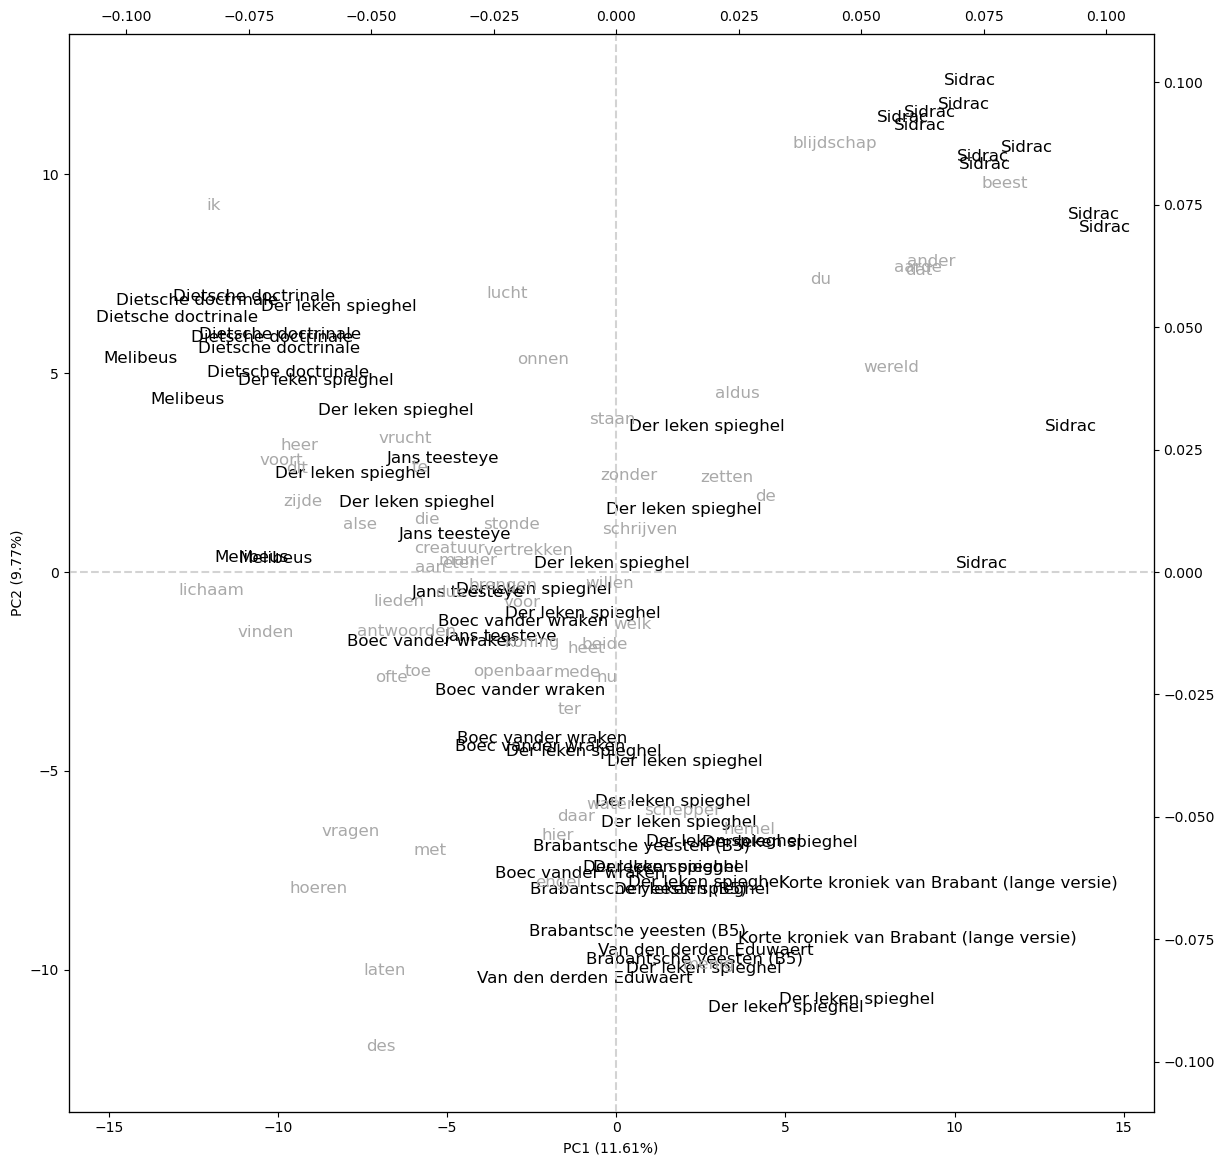

In [83]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

Lekenspiegel lijkt de lijm te zijn? Rolling!!

## Verification

In [86]:
params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': 'word',
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
epics = segment_df[segment_df['genre'].isin(['Epiek', 'Proza'])].copy().reindex()
epics['text'] = epics['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
vectorizer.fit(epics['text'])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

(840, 10000)

In [89]:
num_iter = 250
total_features = len(vectorizer.get_feature_names_out())
num_rnd_features = int(total_features * .5)
n_top_neighbors = 5

target_titles = [#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                 'Korte kroniek van Brabant (lange versie)',
                 'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken',
                 'Sidrac'
                ]

results = []

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    top_neighbors = neighbors.most_common(n_top_neighbors)
    summed = sum(neighbors.values())
    top_neighbors = [f'{k} ({(v / summed) * 100:.2f}%)' for k, v in top_neighbors]
    
    results.append([target_title] + top_neighbors)
    
results = pd.DataFrame(results, columns=['Target']+[f'Rank {i + 1}' for i in range(n_top_neighbors)])
results

Brabantsche yeesten (B5): 100%|███████████████████| 4/4 [00:02<00:00,  1.54it/s]
Korte kroniek van Brabant (korte versie 1): 0it [00:00, ?it/s]
Melibeus: 100%|███████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]
Boec Exemplaer: 0it [00:00, ?it/s]
Sidrac: 100%|███████████████████████████████████| 12/12 [00:07<00:00,  1.57it/s]


,Target,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
0,Korte kroniek van Brabant (lange versie),Brabantsche yeesten (B4-5) (71.80%),Brabantsche yeesten (B1-3) (18.80%),Spiegel historiael (P1-P4) (5.40%),Rijmkroniek van Holland (1.60%),Spiegel historiael (P4) (1.00%)
1,Brabantsche yeesten (B5),Van den derden Eduwaert (52.80%),Brabantsche yeesten (B4-5) (27.40%),Rijmkroniek van Woeringen (4.00%),Roman van Caesar (2.70%),Borchgrave van Couchi (2.50%)
2,Korte kroniek van Brabant (korte versie 1),None,None,None,None,None
3,Der leken spieghel,Boec vander wraken (21.98%),Jans teesteye (15.93%),Melibeus (5.98%),Der ystorien bloeme (5.84%),Dietsche doctrinale (5.62%)
4,Jans teesteye,Boec vander wraken (39.20%),Der leken spieghel (11.50%),Melibeus (9.80%),Dietsche doctrinale (6.50%),Der minnen loep (4.00%)
5,Van den derden Eduwaert,Brabantsche yeesten (B5) (54.80%),Brabantsche yeesten (B1-3) (16.40%),Brabantsche yeesten (B4-5) (9.40%),Spiegel historiael (P5) (4.80%),Boec vander wraken (3.80%)
6,Melibeus,Dietsche doctrinale (65.30%),Boec vander wraken (12.20%),Jans teesteye (11.10%),Der leken spieghel (4.60%),Rose (1.80%)
7,Boec Exemplaer,None,None,None,None,None
8,Dietsche doctrinale,Melibeus (64.34%),Jans teesteye (13.94%),Boec vander wraken (12.63%),Der leken spieghel (6.00%),Alexanders geesten (0.46%)
9,Boec vander wraken,Jans teesteye (23.93%),Der leken spieghel (15.60%),Van den derden Eduwaert (14.67%),Brabantsche yeesten (B5) (9.20%),Melibeus (6.60%)


## Feature analysis

### "Oeuvre"

In [236]:
BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                 'Brabantsche yeesten (B5)',
                                 'Korte kroniek van Brabant (korte versie 1)',
                                 'Korte kroniek van Brabant (lange versie)',
                                 'Der leken spieghel', 'Jans teesteye', 
                                 'Van den derden Eduwaert', 'Melibeus', 'Boec Exemplaer', 
                                 'Dietsche doctrinale', 'Boec vander wraken'])

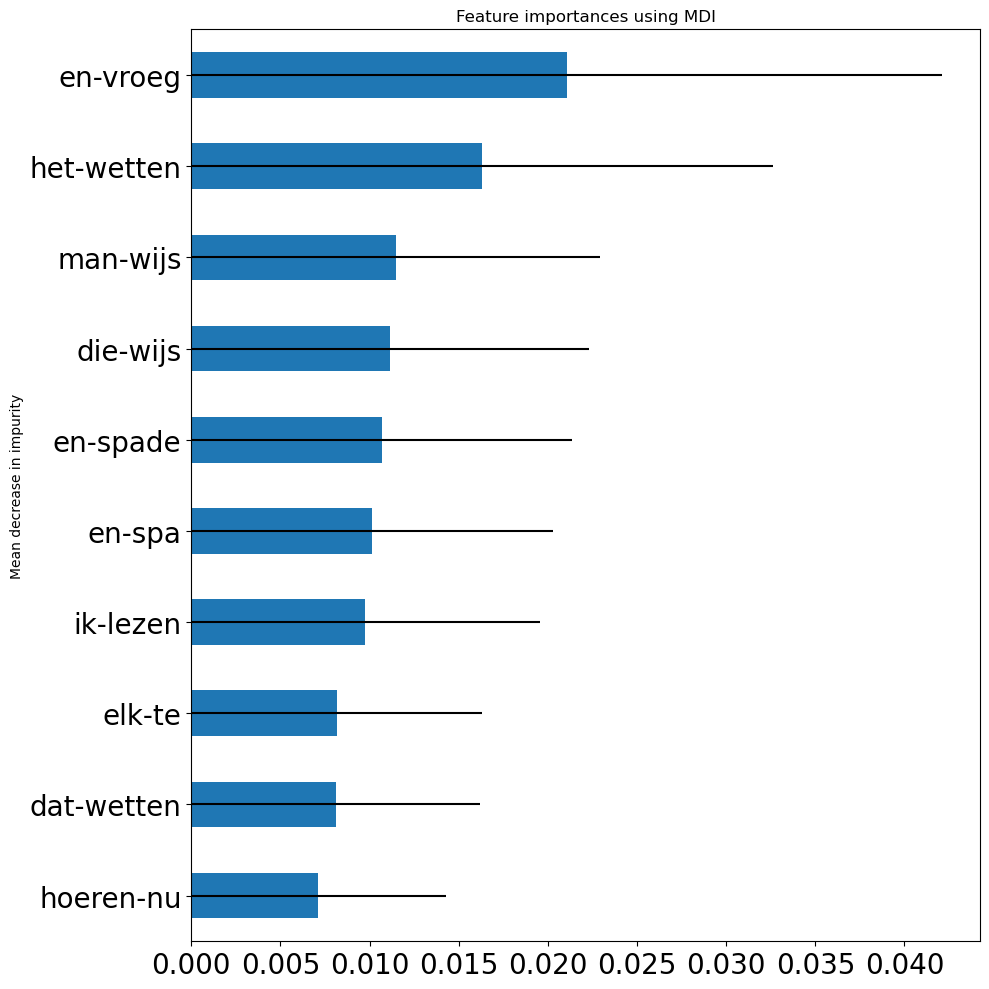

In [237]:
classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



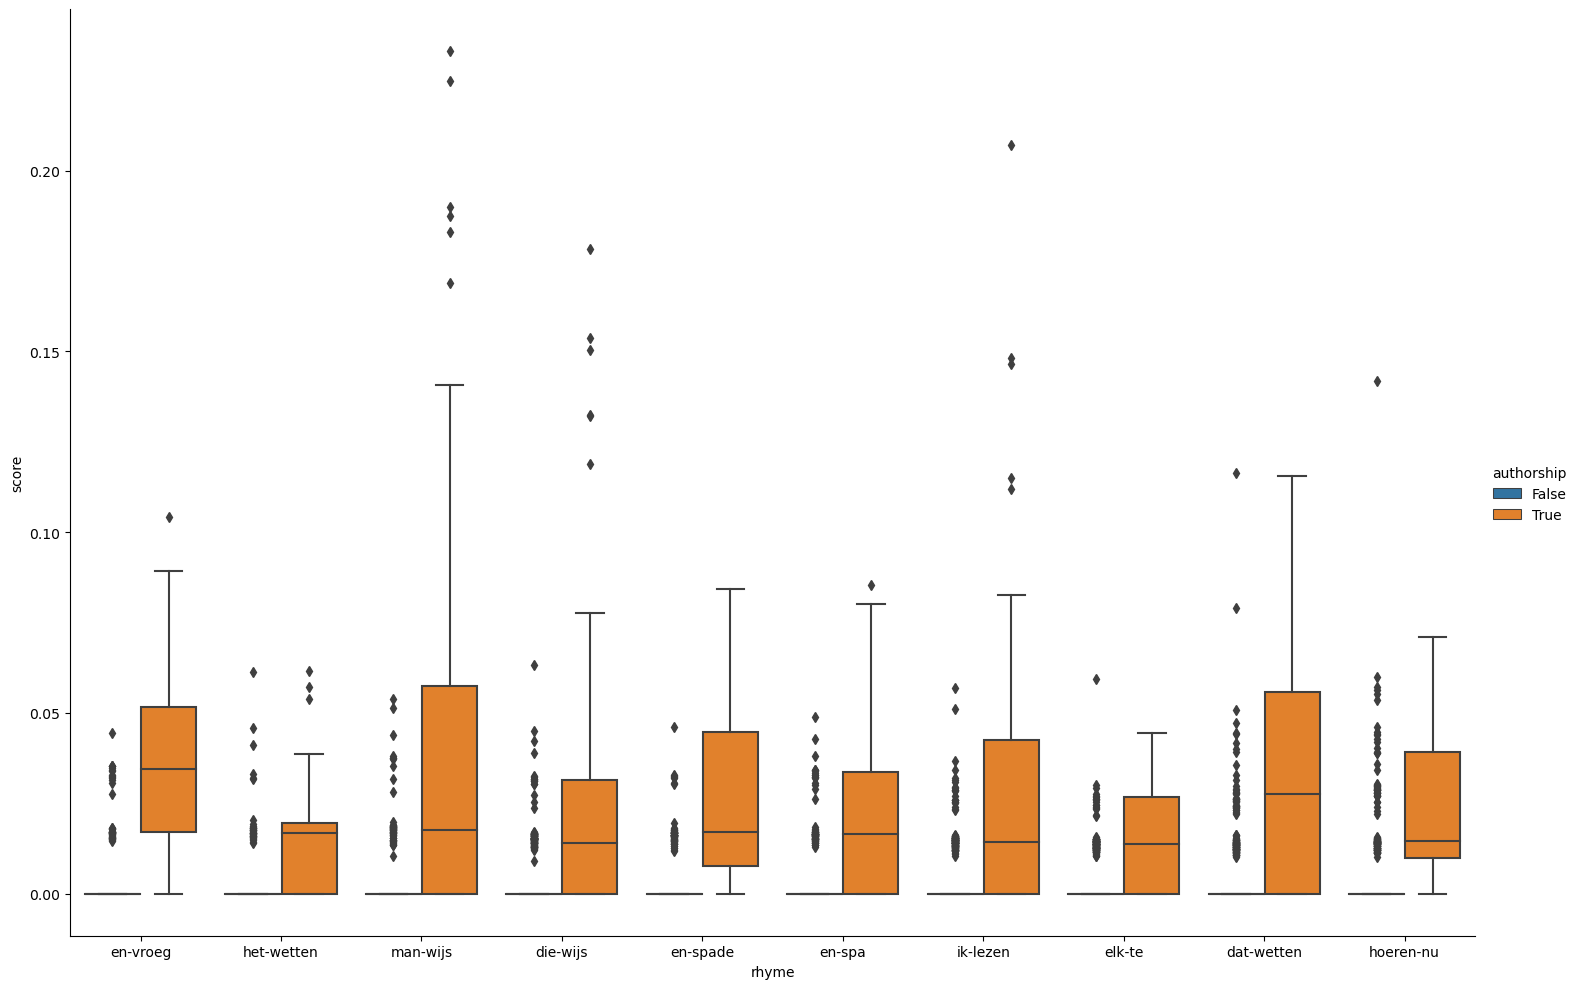

In [238]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);

## Jans teesteye

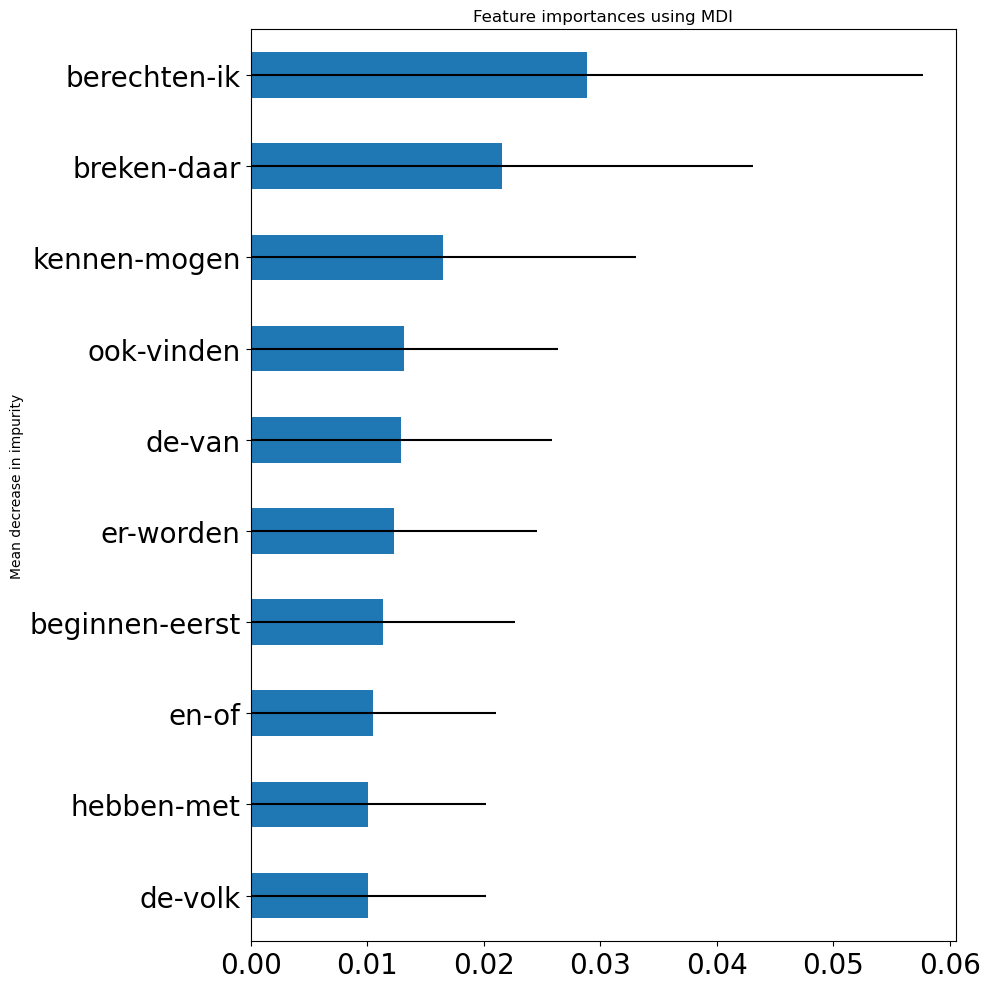

In [239]:
epics = epics[epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                   'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken'])]
segment_X = vectorizer.transform(epics['text']).toarray()

BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'] == 'Jans teesteye'

classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



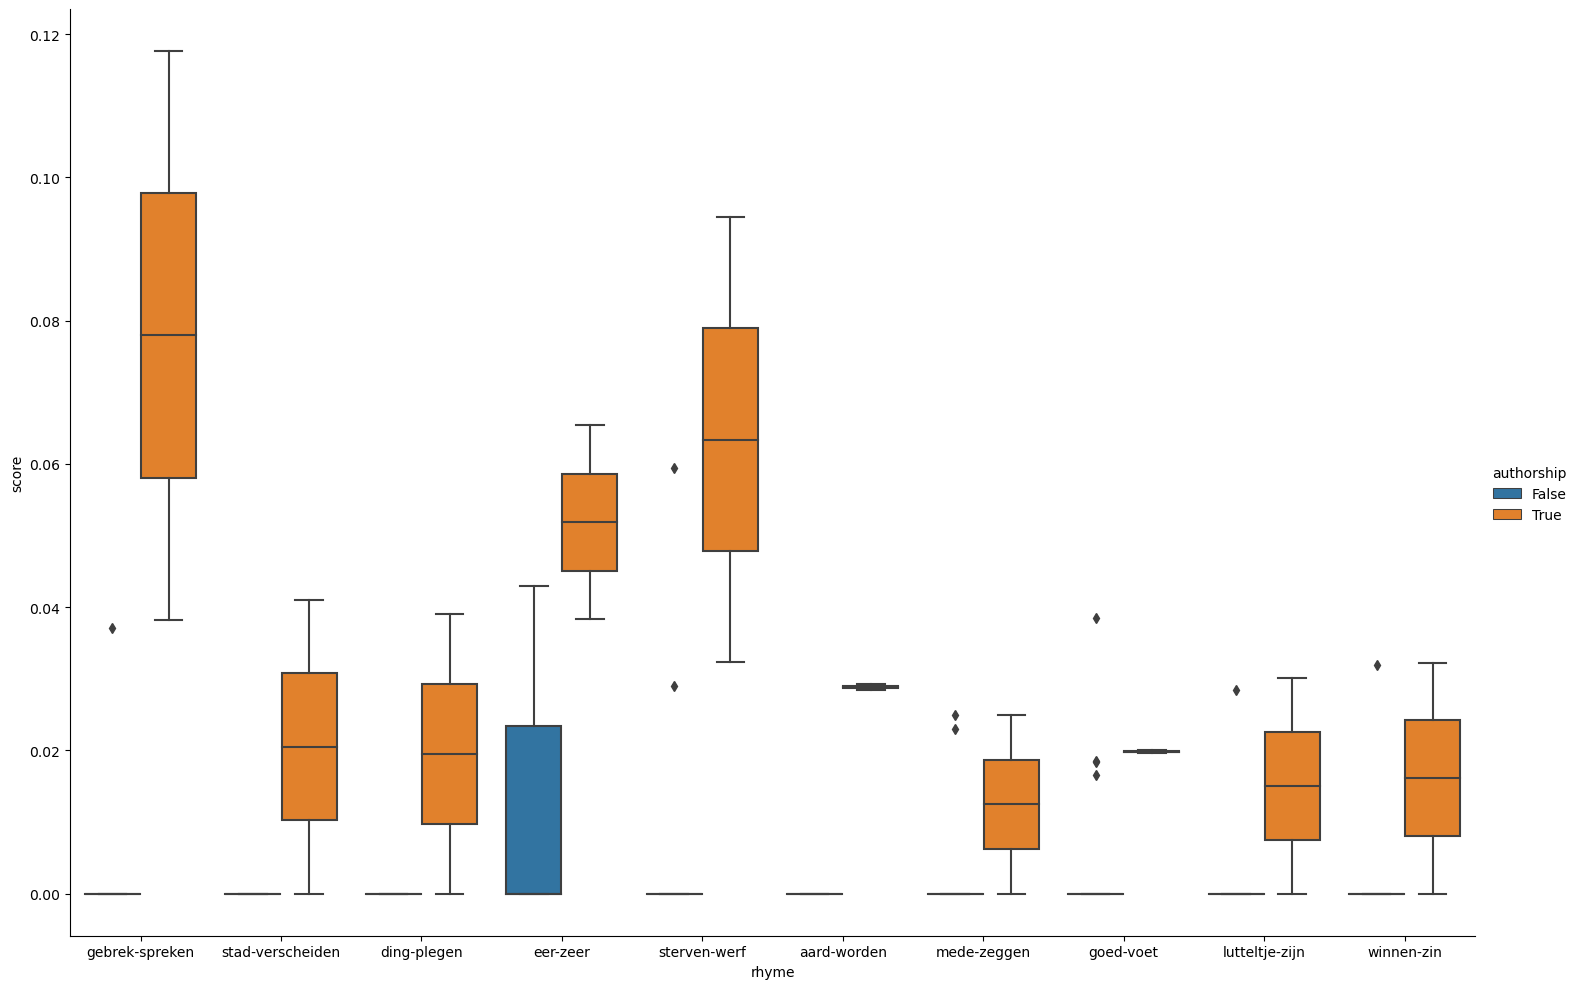

In [156]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);